# PCA on High-Level Dimensions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display
import analysis_utils as au
import altair as alt
import plot

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

In [3]:
try:
    df_raw = pd.read_csv('./data/super_experiment_design_space.csv')
    print(f"Successfully loaded raw dataset. Shape: {df_raw.shape}")
except FileNotFoundError:
    print("Error: './data/super_experiment_design_space.csv' not found.")

df_pca_features, numerical_cols, categorical_cols, df_processed, preprocessor = au.preprocess(df_raw, merge_conflict_dimensions=False)
print("\nPreprocessing complete.")
display(df_pca_features.head())
assert df_pca_features[df_pca_features.isnull().any(axis=1)].size == 0

Successfully loaded raw dataset. Shape: (393, 26)

Preprocessing complete.


,Task 2 Response Probability,Inter-task SOA,Distractor SOA,Task 1 CSI,Task 2 CSI,RSI,Switch Rate,Task 1 Difficulty,Task 2 Difficulty,Inter-task SOA is NA,Distractor SOA is NA,Task 2 CSI is NA,Task 2 Difficulty is NA,Response Set Overlap Mapped,RSI is Predictable,Task 1 Stimulus-Response Mapping Mapped,Task 1 Cue Type Mapped,Task 2 Stimulus-Response Mapping Mapped,Task 2 Cue Type Mapped,Trial Transition Type Mapped,Intra-Trial Task Relationship Mapped,Stimulus-Stimulus Congruency Mapped,Stimulus-Response Congruency Mapped
0,1,1875.0,0.0,0,0.0,1000.0,0.0,0.0,0.000000,0,1,0,0,RSO_Identical,1,SRM_Arbitrary,TCT_Implicit,SRM2_Arbitrary,TCT2_Implicit,TTT_Pure,ITTR_Same,SS_NA,SR_NA
1,1,3750.0,0.0,0,0.0,1000.0,0.0,0.5,0.500000,0,1,0,0,RSO_Identical,1,SRM_Arbitrary,TCT_Implicit,SRM2_Arbitrary,TCT2_Implicit,TTT_Pure,ITTR_Same,SS_NA,SR_NA
2,1,6200.0,0.0,0,0.0,1000.0,0.0,0.5,0.500000,0,1,0,0,RSO_Identical,1,SRM_Arbitrary,TCT_Implicit,SRM2_Arbitrary,TCT2_Implicit,TTT_Pure,ITTR_Same,SS_NA,SR_NA
3,0,150.0,0.0,0,0.0,1000.0,0.0,0.0,0.369963,1,1,1,1,RSO_NA,1,SRM_Compatible,TCT_Implicit,SRM2_NA,TCT2_NA,TTT_Pure,ITTR_NA,SS_NA,SR_NA
4,0,150.0,0.0,0,0.0,1000.0,0.0,0.0,0.369963,1,0,1,1,RSO_NA,1,SRM_Compatible,TCT_Implicit,SRM2_NA,TCT2_NA,TTT_Pure,ITTR_NA,SS_Incongruent,SR_NA


### Exploratory Data Analysis

In [5]:
# List of the original categorical columns we want to inspect
categorical_columns_to_explore = [
    'Response Set Overlap',
    'Stimulus-Stimulus Congruency',
    'Stimulus-Response Congruency',
    #'Stimulus Bivalence & Congruency',
    'Task 1 Stimulus-Response Mapping',
    'Task 1 Cue Type',
    'Task 2 Stimulus-Response Mapping',
    'Task 2 Cue Type'
]
numeric_columns_to_explore = [
    'Inter-task SOA',
    'Distractor SOA',
    'Task 1 CSI',
    'Task 2 CSI', 
    'Task 2 Difficulty'
]

# Loop through the columns and print their value counts
for col in categorical_columns_to_explore:
    print(f"\nValue counts for column: '{col}'")
    # Use dropna=False to explicitly see the count of any missing values (NaNs)
    print(df_processed[col].value_counts(dropna=False))
    print("-" * 30)

print("-" * 60)
print("Review the counts above. If a sub-category has very few examples (e.g., < 5-10),")
print("it is generally better to collapse it into a broader category for the PCA.")
print("This analysis should guide the modifications to the mapping functions in Stage 3.")

for col in numeric_columns_to_explore:
    print(col, au.check_skewness(df_processed[col]))

print("-" * 60)
print("Review the skewness of the numeric columns. If they are skewed it'll be better to")
print("impute with the median instead of the mean.")


Value counts for column: 'Response Set Overlap'
Response Set Overlap
Identical                              134
NaN                                    118
Disjoint - Effector                     71
Disjoint - Modality                     32
Disjoint - Category (Same Modality)     23
Disjoint - Modality (Standard)           8
Disjoint - Modality (Non-Standard)       7
Name: count, dtype: int64
------------------------------

Value counts for column: 'Stimulus-Stimulus Congruency'
Stimulus-Stimulus Congruency
Incongruent                     107
NaN                             106
Neutral                         104
Congruent                        70
Neutral (Feature Similar)         3
Neutral (Feature Dissimilar)      3
Name: count, dtype: int64
------------------------------

Value counts for column: 'Stimulus-Response Congruency'
Stimulus-Response Congruency
NaN            343
Congruent       23
Incongruent     23
Neutral          4
Name: count, dtype: int64
-------------------------

## PCA Fitting

In [6]:
pipeline = au.create_pca_pipeline(numerical_cols, categorical_cols)
pipeline.fit(df_pca_features)
pca_results = pipeline.transform(df_pca_features)
column_names = [f'PC{i+1}' for i in range(pca_results.shape[1])]

# 5. Create a Pandas DataFrame with the specified column names
pca_df = pd.DataFrame(pca_results, columns=column_names)
print("PCA pipeline fitted successfully.")

PCA pipeline fitted successfully.



--- Explained Variance ---
PC1: Explained Variance = 0.204, Cumulative Variance = 0.204
PC2: Explained Variance = 0.161, Cumulative Variance = 0.365
PC3: Explained Variance = 0.115, Cumulative Variance = 0.480
PC4: Explained Variance = 0.090, Cumulative Variance = 0.570
PC5: Explained Variance = 0.067, Cumulative Variance = 0.637
PC6: Explained Variance = 0.059, Cumulative Variance = 0.696
PC7: Explained Variance = 0.054, Cumulative Variance = 0.750
PC8: Explained Variance = 0.040, Cumulative Variance = 0.789
PC9: Explained Variance = 0.035, Cumulative Variance = 0.824
PC10: Explained Variance = 0.027, Cumulative Variance = 0.851
PC11: Explained Variance = 0.021, Cumulative Variance = 0.872
PC12: Explained Variance = 0.018, Cumulative Variance = 0.890
PC13: Explained Variance = 0.016, Cumulative Variance = 0.906
PC14: Explained Variance = 0.015, Cumulative Variance = 0.921
PC15: Explained Variance = 0.014, Cumulative Variance = 0.935
PC16: Explained Variance = 0.012, Cumulative Varian

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49
Task 2 Response Probability,0.155,0.437,0.356,-0.120,0.176,-0.047,-0.342,0.120,-0.074,0.087,-0.167,0.138,0.155,-0.012,-0.109,0.064,0.184,0.009,0.230,0.013,0.172,-0.043,-0.155,0.119,-0.322,0.066,-0.002,0.112,-0.062,-0.095,0.204,0.168,-0.143,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000
Inter-task SOA,0.060,0.200,0.204,-0.223,0.365,-0.398,0.712,-0.186,0.033,0.071,0.027,-0.045,0.009,-0.014,0.016,0.000,-0.071,0.022,-0.023,0.071,0.057,0.029,0.053,0.059,0.006,0.028,-0.000,0.023,0.004,0.000,0.001,0.005,-0.003,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000
Distractor SOA,0.018,-0.085,-0.240,0.214,0.776,0.270,0.013,0.366,-0.171,0.009,0.190,0.061,-0.047,-0.011,0.010,-0.003,0.017,0.028,-0.045,-0.029,-0.034,-0.001,0.008,0.036,-0.022,-0.013,-0.005,-0.004,0.000,-0.005,0.015,0.003,-0.004,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000
Task 1 CSI,0.068,-0.436,0.448,-0.066,0.007,-0.079,-0.043,0.144,0.040,-0.164,0.257,0.061,0.268,-0.066,-0.276,-0.320,0.182,0.278,-0.134,0.239,-0.154,-0.045,0.036,0.055,-0.001,0.013,-0.034,-0.039,0.008,0.004,-0.003,-0.021,0.006,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000
Task 2 CSI,0.153,-0.436,0.381,0.074,-0.016,-0.221,-0.022,0.257,-0.027,-0.025,0.066,0.139,-0.185,0.033,0.121,0.428,-0.310,-0.218,0.125,-0.239,0.183,0.042,-0.023,-0.069,0.018,0.023,0.031,0.032,-0.005,-0.005,0.005,0.030,-0.019,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000
RSI,-0.115,-0.144,0.368,-0.246,0.063,0.638,0.098,-0.385,-0.385,0.067,-0.027,-0.129,-0.052,0.027,0.012,0.018,-0.055,-0.035,0.014,-0.074,0.099,0.010,-0.060,-0.047,0.016,-0.008,-0.002,0.024,-0.015,-0.000,-0.015,0.002,0.005,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000
Switch Rate,0.414,-0.129,-0.094,-0.001,-0.118,0.338,0.264,0.046,0.418,0.436,0.075,0.115,0.188,-0.106,-0.104,0.043,0.168,-0.115,0.201,-0.065,0.091,-0.005,0.013,0.009,-0.152,-0.169,0.002,-0.049,-0.008,0.025,-0.043,-0.079,0.049,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000
Task 1 Difficulty,-0.202,0.196,0.262,0.417,-0.286,0.065,0.315,0.465,-0.227,0.316,-0.103,-0.208,-0.072,0.021,-0.061,-0.149,0.037,0.069,-0.050,-0.114,-0.089,-0.012,-0.081,0.036,0.032,0.012,0.001,-0.006,0.033,-0.019,0.020,0.004,0.006,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000
Task 2 Difficulty,-0.098,0.195,0.211,0.646,0.010,0.111,0.104,-0.361,0.143,-0.308,0.247,0.243,0.051,-0.011,-0.064,0.171,0.158,-0.132,0.071,0.039,-0.005,-0.030,0.091,-0.055,0.005,0.040,0.006,0.009,-0.017,0.001,-0.022,0.039,-0.028,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000
Inter-task SOA is NA_0,0.063,0.172,0.149,-0.062,0.068,0.020,-0.097,0.062,0.032,-0.005,-0.051,0.104,0.039,-0.019,0.075,-0.023,0.033,0.032,0.088,-0.062,-0.036,0.022,0.073,-0.018,0.492,-0.338,0.019,-0.078,0.060,-0.038,-0.085,-0.047,0.031,0.007,0.001,0.086,-0.023,0.078,-0.018,0.139,-0.051,-0.192,0.104,0.317,0.027,0.312,-0.279,-0.373,-0.000


Sparseness of top 3 loadings: 0.36059191997680246


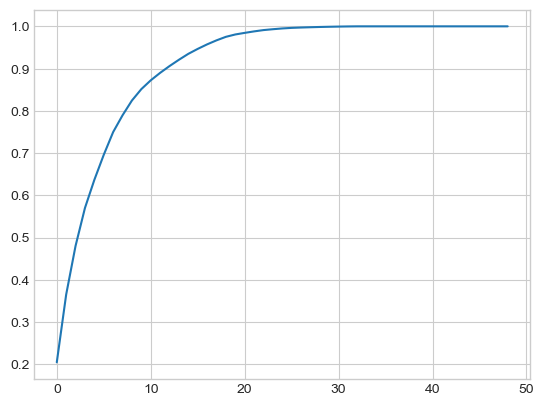

In [7]:
pca = pipeline.named_steps['pca']
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("\n--- Explained Variance ---")
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
    if cum_var > 0.95: break
    print(f"PC{i+1}: Explained Variance = {var:.3f}, Cumulative Variance = {cum_var:.3f}")

plt.plot(range(len(cumulative_variance)), cumulative_variance)
with open("cumulative_variance.tsv", 'w') as cumulative_variance_file:
    cumulative_variance_file.write("PC\tcum_var\n")
    cumulative_variance_file.write("0\t0\n")
    [cumulative_variance_file.write(f"{i+1}\t{cum_var*100}\n") for i, cum_var in enumerate(cumulative_variance) if cum_var < 0.9995]
    
loadings = au.get_component_loadings(pipeline, numerical_cols, categorical_cols)
print("\n--- Principal Component Loadings ---")
display(loadings.round(3))
print("Sparseness of top 3 loadings:", np.mean(au.get_loadings_sparseness(loadings.to_numpy()[:,:3])))

### Top weights for the first four components

In [8]:
display(loadings["PC1"].sort_values(key=abs, ascending=False).round(3)[:16])

Switch Rate                                               0.414
Task 2 Cue Type Mapped_TCT2_NA                           -0.245
Task 2 Stimulus-Response Mapping Mapped_SRM2_NA          -0.245
Task 2 Difficulty is NA_1                                -0.245
Task 2 Difficulty is NA_0                                 0.245
Task 2 CSI is NA_0                                        0.243
Task 2 CSI is NA_1                                       -0.243
Response Set Overlap Mapped_RSO_NA                       -0.241
Intra-Trial Task Relationship Mapped_ITTR_NA             -0.237
Trial Transition Type Mapped_TTT_Pure                    -0.227
Intra-Trial Task Relationship Mapped_ITTR_Different       0.219
Task 1 Difficulty                                        -0.202
Task 2 Stimulus-Response Mapping Mapped_SRM2_Arbitrary    0.178
Task 2 Cue Type Mapped_TCT2_Implicit                      0.175
Task 2 Response Probability                               0.155
Task 2 CSI                              

In [9]:
display(loadings["PC2"].sort_values(key=abs, ascending=False).round(3)[:16])

Task 2 Response Probability                               0.437
Task 2 CSI                                               -0.436
Task 1 CSI                                               -0.436
Inter-task SOA                                            0.200
Task 1 Difficulty                                         0.196
Task 2 Difficulty                                         0.195
Task 2 Cue Type Mapped_TCT2_Implicit                      0.180
Inter-task SOA is NA_1                                   -0.172
Inter-task SOA is NA_0                                    0.172
RSI                                                      -0.144
Task 1 Cue Type Mapped_TCT_Implicit                       0.141
Task 1 Cue Type Mapped_TCT_Arbitrary                     -0.141
Response Set Overlap Mapped_RSO_Disjoint                  0.134
Task 2 Cue Type Mapped_TCT2_Arbitrary                    -0.131
Switch Rate                                              -0.129
Task 2 Stimulus-Response Mapping Mapped_

In [10]:
display(loadings["PC3"].sort_values(key=abs, ascending=False).round(3)[:16])

Task 1 CSI                                        0.448
Task 2 CSI                                        0.381
RSI                                               0.368
Task 2 Response Probability                       0.356
Task 1 Difficulty                                 0.262
Distractor SOA                                   -0.240
Task 2 Difficulty                                 0.211
Inter-task SOA                                    0.204
Inter-task SOA is NA_0                            0.149
Inter-task SOA is NA_1                           -0.149
Distractor SOA is NA_1                            0.126
Distractor SOA is NA_0                           -0.126
Response Set Overlap Mapped_RSO_Disjoint          0.115
Stimulus-Stimulus Congruency Mapped_SS_NA         0.105
Trial Transition Type Mapped_TTT_Pure             0.104
Stimulus-Stimulus Congruency Mapped_SS_Neutral   -0.100
Name: PC3, dtype: float64

In [11]:
display(loadings["PC4"].sort_values(key=abs, ascending=False).round(3)[:16])

Task 2 Difficulty                                          0.646
Task 1 Difficulty                                          0.417
RSI                                                       -0.246
Inter-task SOA                                            -0.223
Distractor SOA                                             0.214
Task 1 Stimulus-Response Mapping Mapped_SRM_Compatible     0.179
Task 1 Stimulus-Response Mapping Mapped_SRM_Arbitrary     -0.169
Distractor SOA is NA_1                                    -0.132
Distractor SOA is NA_0                                     0.132
Task 2 Cue Type Mapped_TCT2_Arbitrary                      0.131
Task 1 Cue Type Mapped_TCT_Implicit                       -0.122
Task 1 Cue Type Mapped_TCT_Arbitrary                       0.122
Intra-Trial Task Relationship Mapped_ITTR_Different        0.121
Task 2 Response Probability                               -0.120
Task 2 Stimulus-Response Mapping Mapped_SRM2_Compatible    0.080
Task 2 Cue Type Mapped_TC

### Find Centroids of Paradigms and Interpolate Them

### Plot Experimental Conditions

In [12]:
# --- 5. Define Tooltip Columns ---
tooltip_cols = [
    alt.Tooltip('Experiment:N', title='Experiment'),
    alt.Tooltip('Paradigm:N', title='Paradigm Class'),
    alt.Tooltip('Task 2 Response Probability:Q', title='T2 Response Probability', format='.2f'),
    alt.Tooltip('Inter-task SOA:N', title='Inter-task SOA'),
    alt.Tooltip('Distractor SOA:N', title='Distractor SOA'),
    alt.Tooltip('Task 1 CSI:Q', title='T1 CSI', format='.0f'),
    alt.Tooltip('Task 2 CSI:Q', title='T2 CSI', format='.0f'),
    alt.Tooltip('RSI:Q', title='RSI', format='.0f'),
    alt.Tooltip('RSI is Predictable:N', title='RSI Predictable'),
    alt.Tooltip('Switch Rate:Q', title='Switch Rate (%)', format='.1f'),
    alt.Tooltip('Trial Transition Type:N', title='Transition Type'),
    alt.Tooltip('Stimulus Bivalence & Congruency:N', title='Stimulus Bivalence & Congruency'),
    alt.Tooltip('Response Set Overlap:N', title='Response Set Overlap'),
    alt.Tooltip('Task 1 Stimulus-Response Mapping:N', title='T1 Stimulus-Response Mapping'),
    alt.Tooltip('Task 2 Stimulus-Response Mapping:N', title='T2 Stimulus-Response Mapping'),
    alt.Tooltip('Task 1 Difficulty:Q', title='T1 Difficulty', format='.1f'),
    alt.Tooltip('Task 2 Difficulty:Q', title='T2 Difficulty', format='.1f'),
    alt.Tooltip('Task 2 CSI is NA:N', title='T2 CSI is N/A'),
    alt.Tooltip('Task 2 Difficulty is NA:N', title='T2 Difficulty is N/A'),
    alt.Tooltip('Inter-task SOA is NA:N', title='Inter-task SOA is N/A'),
    alt.Tooltip('Distractor SOA is NA:N', title='Distractor SOA is N/A')
]
# --- 1. Combine data and calculate centroids ---
plot_df = pd.concat([
    df_processed.reset_index(drop=True),
    pca_df.reset_index(drop=True)
], axis=1)
plot_df['Point Type'] = 'Empirical Data'

centroids_df = au.find_centroids(plot_df[[c for c in plot_df.columns if c.startswith("PC")] + ["Paradigm"]], paradigm_col='Paradigm')
centroids_df = pd.DataFrame.from_dict(centroids_df, orient='index').reset_index()
centroids_df = centroids_df.rename(columns={'index': 'Paradigm'})
centroids_df['Point Type'] = 'Centroid'

# --- 2. Generate interpolated points using the new utility function ---
interpolation_pairs = [
    ('Dual-Task_PRP', 'Task Switching'),
    ('Dual-Task_PRP', 'Interference'),
    ('Task Switching', 'Interference')
]

model_artifacts_pca = {'type': 'pca', 'pipeline': pipeline}

interpolated_df = au.generate_interpolated_points(
    latent_space_df=plot_df,
    model_artifacts=model_artifacts_pca,
    interpolation_pairs=interpolation_pairs
)

# --- 3. Combine all dataframes for plotting ---
final_plot_df = pd.concat([plot_df, centroids_df, interpolated_df], ignore_index=True)
final_plot_df['Parent1'] = final_plot_df['Parent1'].fillna('N/A')
final_plot_df['Parent2'] = final_plot_df['Parent2'].fillna('N/A')
final_plot_df = plot.add_na_mask_from_flag(final_plot_df)

# Now, call the plotting function from plot.py
# (Assuming you have also moved the plotting logic there)
pca_chart = plot.create_latent_space_plot(final_plot_df, "PC1", "PC2", "PC1 (Procedural Stability <-> Dynamic Coordination)",
                                          "PC2 (Proactive Preparation vs. Reactive Dual-Task Coordination)",
                                          "Cognitive Control Experimental Conditions", tooltip_cols,
                                          has_interpolation=True, output_filename="pca_plot.pdf")
pca_chart

alt.LayerChart(...)

#### Sparseness Measure of first four PCs (to match MOFA+'s number of factors)

In [13]:
np.mean(au.get_loadings_sparseness(loadings[["PC1", "PC2", "PC3", "PC4"]].to_numpy()))

np.float64(0.37771449748010444)

#### Paradigm Separation Validation

In [14]:
au.validate_paradigm_separation(plot_df, ["PC1", "PC2"], target_col='Paradigm')

{'accuracy': 1.0,
 'classification_report': {'Dual-Task_PRP': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 4.0},
  'Interference': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 4.0},
  'Single-Task': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 1.0},
  'Task Switching': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 8.0},
  'accuracy': 1.0,
  'macro avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 17.0},
  'weighted avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 17.0}},
 'confusion_matrix': array([[4, 0, 0, 0],
        [0, 4, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 8]]),
 'model_name': 'KNeighborsClassifier(n_neighbors=3)',
 'feature_names': ['PC1', 'PC2'],
 'class_names': ['Dual-Task_PRP',
  'Interference',
  'Single-Task',
  'Task Switching'],
 'test_size': 17,
 'train_size': 376}